## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import warnings

from tqdm import tqdm
import zlib

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
from matplotlib.ticker import PercentFormatter

### Load Data For EDA
There are 4 files found in the data directory:

- IdLookupTable - TBD
- SampleSubmission - TBD
- test - TBD
- training - TBD 

We must load this data in order to perform EDA.  


In [51]:

#https://realpython.com/python-zip-function/#:~:text=%20Using%20the%20Python%20zip%20()%20Function%20for,zip%20()%20function%20works%20differently%20in...%20More

df, git_path = {}, 'data/'
for file_name, file_ref, n, t in zip(['IdLookupTable.csv', 'SampleSubmission.csv', 'test.csv', 'training.csv'],
                        ['id_lookup', 'sample_submission', 'test', 'train'],
                        [['row_id', 'image_id', 'feature_name', 'location'],
                            ['row_id', 'location'],
                            ['image_id', 'image'],
                            ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 
                            'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 
                            'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 
                            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 
                            'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 
                            'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'image']],
                            [{'row_id':'uint16', 'image_id':'uint16', 'location':'float32'},
                            {'row_id':'uint16', 'location':'float32'},
                            {'image_id':'uint16', 'image':'object'},
                            {'left_eye_center_x':'float32', 'left_eye_center_y':'float32', 'right_eye_center_x':'float32', 'right_eye_center_y':'float32', 
                            'left_eye_inner_corner_x':'float32', 'left_eye_inner_corner_y':'float32', 'left_eye_outer_corner_x':'float32', 'left_eye_outer_corner_y':'float32', 
                            'right_eye_inner_corner_x':'float32', 'right_eye_inner_corner_y':'float32', 'right_eye_outer_corner_x':'float32', 'right_eye_outer_corner_y':'float32', 
                            'left_eyebrow_inner_end_x':'float32', 'left_eyebrow_inner_end_y':'float32', 'left_eyebrow_outer_end_x':'float32', 'left_eyebrow_outer_end_y':'float32', 
                            'right_eyebrow_inner_end_x':'float32', 'right_eyebrow_inner_end_y':'float32', 'right_eyebrow_outer_end_x':'float32', 'right_eyebrow_outer_end_y':'float32', 
                            'nose_tip_x':'float32', 'nose_tip_y':'float32', 'mouth_left_corner_x':'float32', 'mouth_left_corner_y':'float32', 'mouth_right_corner_x':'float32', 
                            'mouth_right_corner_y':'float32', 'mouth_center_top_lip_x':'float32', 'mouth_center_top_lip_y':'float32', 'mouth_center_bottom_lip_x':'float32', 
                            'mouth_center_bottom_lip_y':'float32', 'image':'object'}]):
    print("Begin file '%s' load" % "".join( (git_path, file_name)))
    print(file_ref)
    df[file_ref] = pd.read_csv("".join( (git_path,file_name) ), names = n, dtype = t, skiprows = 1)
    #If the file contains an image column like in the case of test.csv process those images now. 
    if "image" in df[file_ref]:
        print("\tProcessing %d images..." % df[file_ref].shape[0])
        #Get the row with the image data and store it in the dataframe 
        df[file_ref]['image'] = df[file_ref]["image"].map(lambda x: np.array(list(map(int, x.split(" ")))))
    print("\tEnd File load with shape:", df[file_ref].shape, "\n")

print("Data load complete")

Begin file 'data/IdLookupTable.csv' load
id_lookup
	End File load with shape: (27124, 4) 

Begin file 'data/SampleSubmission.csv' load
sample_submission
	End File load with shape: (27124, 2) 

Begin file 'data/test.csv' load
test
	Processing 1783 images...
	End File load with shape: (1783, 2) 

Begin file 'data/training.csv' load
train
	Processing 7049 images...
	End File load with shape: (7049, 31) 

Data load complete


In [3]:
train, test = df['train'][['image']], df['test'][['image']]


In [52]:
# Check for duplicate train images
train = df['train'].reset_index().copy()
#Get the images and perform a checksum on every image in train: https://www.geeksforgeeks.org/zlib-adler32-in-python/
train['check_sum'] = train.image.map(lambda x: zlib.adler32(x))

#Create a DF to store duplicates, grouping them together and sorting them
train_duplicates = pd.DataFrame(train.groupby(by='check_sum').index.count().sort_values()).reset_index()
#Add a column to keep track of how many of each check sum there are
train_duplicates.columns = ['check_sum', 'number_found']
#Keep the ones where we have > 1 number_found
train_duplicates = train_duplicates[(train_duplicates.number_found > 1)]
#Now do a left outer join back to train_duplicates.  This should only keep the duplicates 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#:~:text=merge%20is%20a%20function%20in%20the%20pandas%20namespace,,the%20index-on-index%20(by%20default)%20and%20column%20(s)-on-index%20join.
train_duplicates = pd.merge(train_duplicates, train[['index', 'check_sum']],  how = 'left', on=['check_sum']).sort_values(by=['number_found', 'check_sum'], ascending = False)


#Now do the same for test:
# Check for duplicate train images
test = df['test'].reset_index().copy()
#Get the images and perform a checksum on every image in train: https://www.geeksforgeeks.org/zlib-adler32-in-python/
test['check_sum'] = test.image.map(lambda x: zlib.adler32(x))
#Create a DF to store duplicates, grouping them together and sorting them
test_duplicates = pd.DataFrame(test.groupby(by='check_sum').index.count().sort_values()).reset_index()
#Add a column to keep track of how many of each check sum there are
test_duplicates.columns = ['check_sum', 'number_found']
#Keep the ones where we have > 1 number_found
test_duplicates = test_duplicates[(test_duplicates.number_found > 1)]
#Now do a left outer join back to train_duplicates.  This should only keep the duplicates 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#:~:text=merge%20is%20a%20function%20in%20the%20pandas%20namespace,,the%20index-on-index%20(by%20default)%20and%20column%20(s)-on-index%20join.
test_duplicates = pd.merge(test_duplicates, test[['index', 'check_sum']],  how = 'left', on=['check_sum']).sort_values(by=['number_found', 'check_sum'], ascending = False)

print("EDA on duplicate data in train and test datasets: ")
print("The train dataset has %d unique images out of the %d duplicate images from the total of %d images" % (len(np.unique(train_duplicates.check_sum)), len(train_duplicates), train.size))
print("The test dataset has %d unique images out of %d duplicate images from the total of %d images" % (len(np.unique(test_duplicates.check_sum)),len(test_duplicates), test.size))

#Clean up:
#We don't really need the check_sum column anymore...so drop it
train.drop(columns=['check_sum'], inplace=True)
test.drop(columns=['check_sum'], inplace=True)

EDA on duplicate data in train and test datasets: 
The train dataset has 543 unique images out of the 1098 duplicate images from the total of 232617 images
The test dataset has 29 unique images out of 60 duplicate images from the total of 7132 images


In [5]:
print(train.size)
print(train_duplicates.size)

225568
3294


[3113 3740 4296 4873 5970 2490 3741 5414 5969 6583 2681 3317 3936 3937
 2678 3935 5066 6149 2774 4574 6243 2773 5141 6858 3665 4801 2316 7013
 4400 6665 6306 6924 4398 4968 3625]


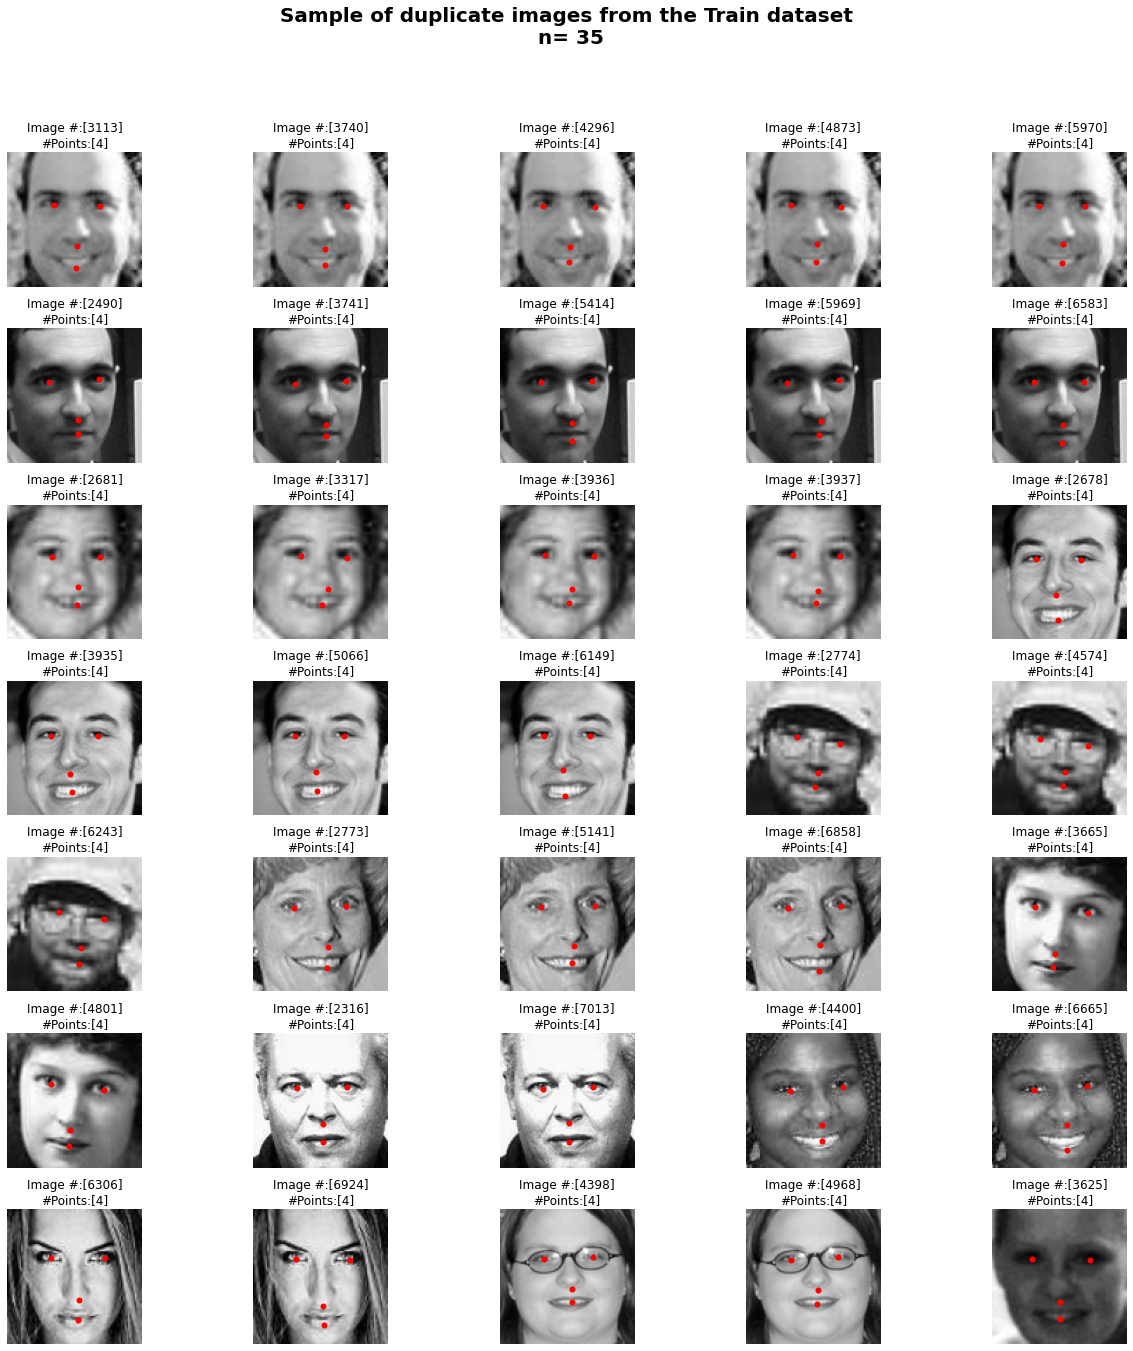

In [7]:

## TRAIN 
# Let's view some of these duplicated train images
fig = plt.figure(figsize=(18,18))
fig.suptitle('Sample of duplicate images from the Train dataset\n n= 35', size = 20,  y = 1.04, weight = 'bold')
#Get the point coordinates for example: mouth_center_top_lip_x
coordinates = [c for c in train.columns if c.endswith('_x') | c.endswith('_y')]
#print(coordinates)
#Get the top 35 duplicate images
idx = train_duplicates.head(35)['index'].values
#For testing, these are the duplicate ID's
print(idx)

match_pts = pd.DataFrame(columns =['Points_Found', 'Count'])

#Loop through and plot each of the 35 images.  
for i, idx in enumerate(idx):
    plt.subplot(7,5,i+1)
    img = train[(train['index'] == idx)].image.values[0].reshape(96,96)
    #These are the points that have been identified on the images
    points = train[(train['index'] == idx)][coordinates].values[0]
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    matching_pts = 0

    for pts in range(0, 30, 2):
        x_point, y_point = (points[pts], points[pts+1])
        if not (np.isnan(x_point)) and not (np.isnan(y_point)):
            matching_pts += 1
            #Add the point to the plot
            plt.plot(x_point, y_point, 'o', color = "red", markersize = 5)

    plt.title("Image #:[%d]\n#Points:[%d]" % (idx, matching_pts))
    if matching_pts in match_pts["Points_Found"].values:
            match_pts.loc[match_pts['Points_Found'] == matching_pts, 'Count'] = match_pts.loc[match_pts['Points_Found'] == matching_pts, 'Count'] + 1
    else:
        match_pts = match_pts.append({'Points_Found':matching_pts,'Count': 1},ignore_index=True)


plt.tight_layout()
plt.show()

[3113 3740 4296 ... 3732 2451 4266]
  Points_Found Count
0            4  1096
1           15     1
2           13     1


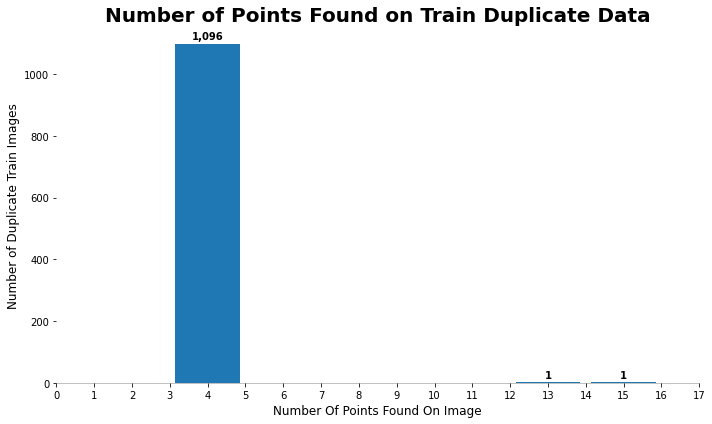

In [15]:
idx = train_duplicates['index'].values
#For testing, these are the duplicate ID's
print(idx)
match_pts = pd.DataFrame(columns =['Points_Found', 'Count'])
coordinates = [c for c in train.columns if c.endswith('_x') | c.endswith('_y')]
#Loop through and plot each of the 35 images.  
for i, idx in enumerate(idx):
    img = train[(train['index'] == idx)].image.values[0].reshape(96,96)
    #These are the points that have been identified on the images
    points = train[(train['index'] == idx)][coordinates].values[0]
    matching_pts = 0

    for pts in range(0, 30, 2):
        x_point, y_point = (points[pts], points[pts+1])
        if not (np.isnan(x_point)) and not (np.isnan(y_point)):
            matching_pts += 1
            
    if matching_pts in match_pts["Points_Found"].values:
            match_pts.loc[match_pts['Points_Found'] == matching_pts, 'Count'] = match_pts.loc[match_pts['Points_Found'] == matching_pts, 'Count'] + 1
            
    else:
        match_pts = match_pts.append({'Points_Found': matching_pts,'Count': 1},ignore_index=True)
        
print(match_pts)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.set_title('Number of Points Found on Train Duplicate Data', fontsize = 20, fontweight = 'bold')
ax.bar(match_pts.Points_Found, match_pts.Count, width = 1.7)
ax.set_xticks(range(0,18,1))
for i, r in match_pts.iterrows():
    plt.text(r.Points_Found, r.Count + 25, format(r.Count, ",d"), 
        horizontalalignment = 'center', verticalalignment = 'center', fontweight ='bold')
ax.spines["top"].set_alpha(.0)
ax.spines["bottom"].set_alpha(.3)
ax.spines["right"].set_alpha(.0)
ax.spines["left"].set_alpha(.0)
ax.set_xlabel("Number Of Points Found On Image", fontsize = 12, horizontalalignment='center')
ax.set_ylabel("Number of Duplicate Train Images", fontsize = 12, horizontalalignment='center')

plt.tight_layout()
plt.show()


In [24]:
print(train_duplicates.columns)

Index(['check_sum', 'number_found', 'index'], dtype='object')


In [36]:
#Do the duplicate Train images have the same labels? Let's test one out. 

#Get only the first images checksum from duplicate train and then get the images that match the check_sum
duplicate_image_chksum = train_duplicates.iloc[0, train_duplicates.columns.get_loc('check_sum')] 
print(duplicate_train_image)
duplicate_image_index = train_duplicates.loc[(train_duplicates.check_sum == duplicate_image_chksum)]['index'].values

#Create an array of all of the coumns with x,y in them
coordinate_columns = [c for c in train.columns if c.endswith('_x') | c.endswith('_y')]

#Get the df so we can display something meaningful
duplicate_image_df = train.loc[(train['index'].isin(duplicate_image_index))][coordinate_columns]

#https://mode.com/example-gallery/python_dataframe_styling/
duplicate_image_df.style\
    .highlight_max(subset=coordinate_columns,color='red')\
    .set_na_rep("N/A").format(None, na_rep="Missing")\
    .highlight_null('blue')
    

3026744882


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
3113,65.922241,38.172161,32.818027,37.570259,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,49.069191,66.461212,Missing,Missing,Missing,Missing,Missing,Missing,48.467289,82.411415
3740,66.150223,38.267910,33.073387,37.702488,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,50.601280,68.517670,Missing,Missing,Missing,Missing,Missing,Missing,50.318577,80.108711
4296,67.401886,38.960995,30.503929,37.720730,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,49.728069,67.177086,Missing,Missing,Missing,Missing,Missing,Missing,49.107948,78.029442
4873,67.189865,38.634968,31.919750,37.472233,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,50.523769,64.990669,Missing,Missing,Missing,Missing,Missing,Missing,49.361012,77.780922
5970,65.417229,38.045616,32.680088,37.651199,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,50.034721,65.260834,Missing,Missing,Missing,Missing,Missing,Missing,49.245884,78.671219


In [48]:
#The lables do not match exactly in the duplicate Train images.  The challenge would be to determine which of the images to keep if we remove all but one of the duplicate images. We have two options:

#1 - Keep the first duplicate and disregard the others - Easy to do, low cost but we risk losing data.
#2 - Take the average for all coordiantes across the duplicate image and apply those coordinates moving forward. A little more work invovled and risk of introducing more errors to the lables. 

#If we were to do #2 this is how the above image would reconcile:
#Take the mean of the columns and create a new DF
duplicate_image_df = pd.DataFrame(train.loc[(train['index'].isin(duplicate_image_index))][coordinate_columns].mean())

#Display results
duplicate_image_df.T.style\
    .set_na_rep("N/A").format(None, na_rep="Missing")\
    .highlight_null('blue')




,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.416290,38.416328,32.199036,37.623383,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,49.991405,66.481491,Missing,Missing,Missing,Missing,Missing,Missing,49.300140,79.400345


## Test Dataset Duplicate Data

In [54]:
test = df['test'].reset_index().copy()
print(test.size)
print(test_duplicates.size)
print(test.size/test_duplicates.size, "% of test data is duplicates")

5349
180
29.716666666666665 % of test data is duplicates


[ 949 1569 1572  942  948 1570  324  391 1242 1248  851 1471  353  386
  913 1537  950  951  352  394  658 1304 1157 1782  771  778  294  389
 1397 1401  329  384  367  387  339]


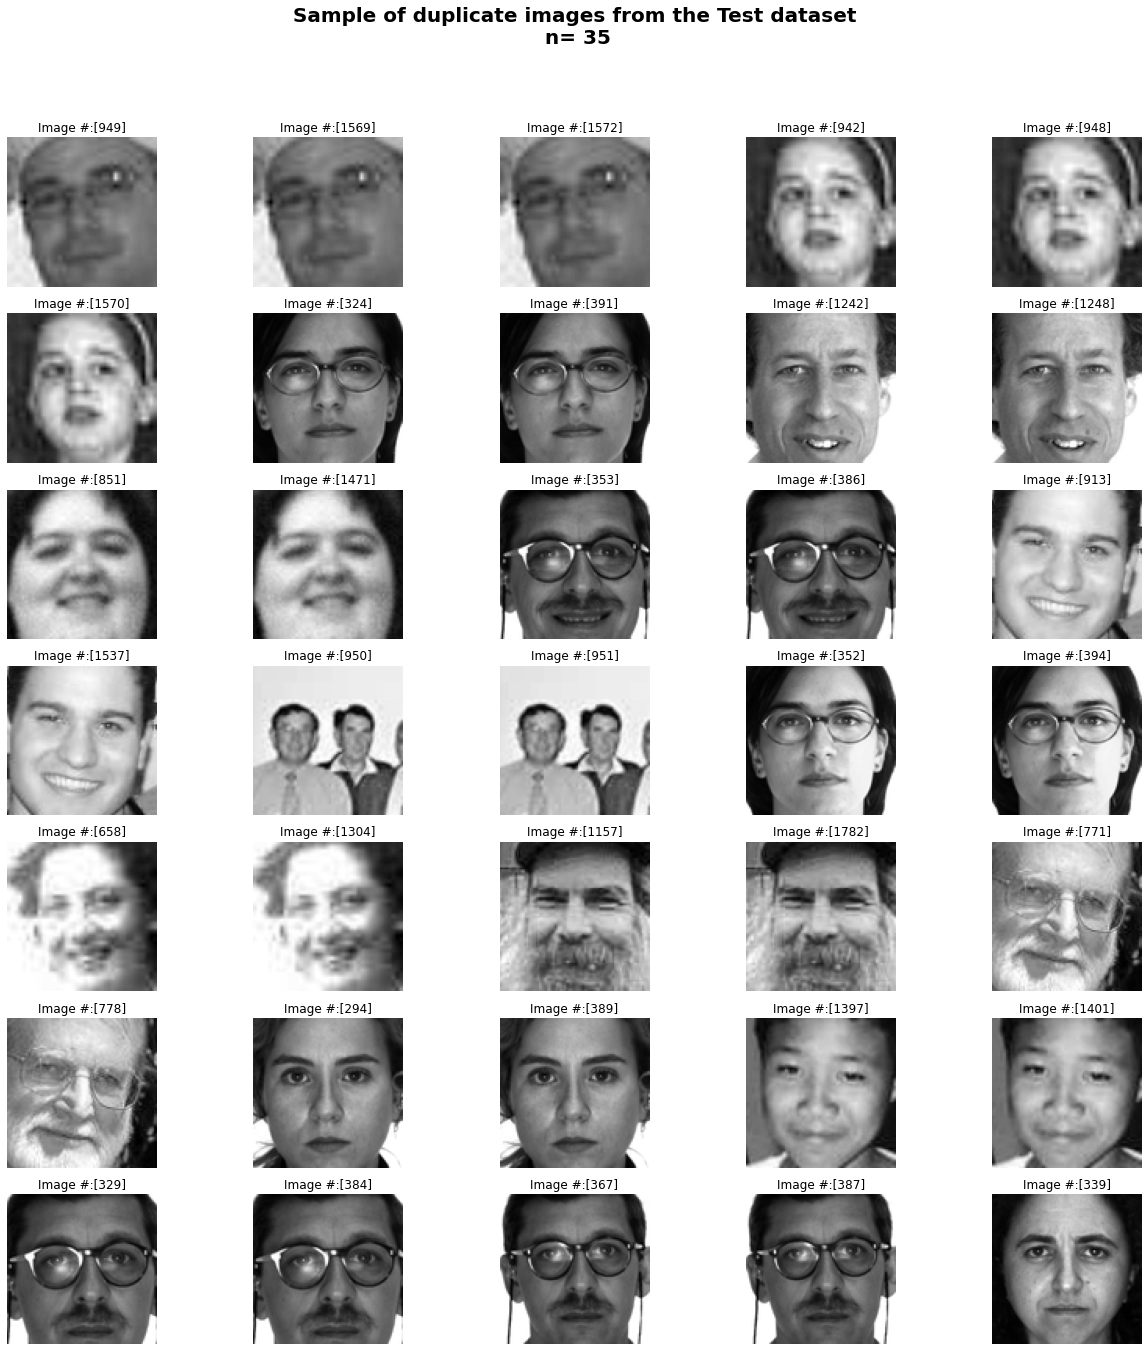

In [13]:
## TEST 
# Let's view some of these duplicated train images
fig = plt.figure(figsize=(18,18))
fig.suptitle('Sample of duplicate images from the Test dataset\n n= 35', size = 20,  y = 1.04, weight = 'bold')
#Get the point coordinates for example: mouth_center_top_lip_x

#Get the top 35 duplicate images
idx = test_duplicates.head(35)['index'].values
#For testing, these are the duplicate ID's
print(idx)

#Loop through and plot each of the 35 images.  
for i, idx in enumerate(idx):
    plt.subplot(7,5,i+1)
    img = test[(test['index'] == idx)].image.values[0].reshape(96,96)
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    plt.title("Image #:[%d]" % (idx))
    
plt.tight_layout()
plt.show()

## Duplication Conclusions -EDA on duplicate data in train and test datasets:
Train:

1. The train dataset has 543 unique images out of the 1098 duplicate images from the total of 232617 images

2. Of the 1098 duplicate images:
    - 1096 of them had 4 points
    - 1 had  13 points
    - 1 had 15 points

Test:

1. The test dataset has 29 unique images out of 60 duplicate images from the total of 7132 images
